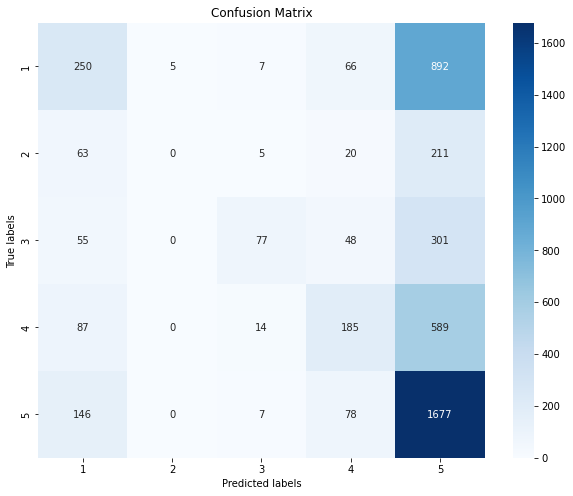

Best Model Classification Report:
              precision    recall  f1-score   support

           1       0.42      0.20      0.27      1220
           2       0.00      0.00      0.00       299
           3       0.70      0.16      0.26       481
           4       0.47      0.21      0.29       875
           5       0.46      0.88      0.60      1908

    accuracy                           0.46      4783
   macro avg       0.41      0.29      0.29      4783
weighted avg       0.44      0.46      0.39      4783


Top 5 Important Features for the Best Model:
issue_reported_day_of_week: 0.1202
response_time_minutes: 0.0981
issue_reported_hour_of_day: 0.0853
sentiment_score: 0.0773
Sub-category_Reverse Pickup Enquiry: 0.0132


In [9]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the data from the SQLite database
conn = sqlite3.connect('balance_customer_support.db')
data = pd.read_sql_query("SELECT * FROM balanced_customer_support", conn)
conn.close()

# Define the target variable 'y'
y = data['CSAT_Score'].astype('category')  # Ensuring 'y' is a categorical type for stratification

# OneHotEncode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data[['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager']])
encoded_feature_names = encoder.get_feature_names_out(['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager'])

# Combine numerical and OneHotEncoded categorical features
X = pd.concat([data[['issue_reported_hour_of_day', 'response_time_minutes', 'issue_reported_day_of_week', 'sentiment_score']], pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)], axis=1)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Confusion matrix
class_labels = [1, 2, 3, 4, 5]

conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred))

# Print the top 5 important features
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_indices[:5]]
top_importances = feature_importances[sorted_indices[:5]]

print("\nTop 5 Important Features for the Best Model:")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")


MLP Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.31      0.32      1220
           2       0.12      0.05      0.07       299
           3       0.28      0.21      0.24       481
           4       0.34      0.28      0.31       875
           5       0.47      0.60      0.53      1908

    accuracy                           0.39      4783
   macro avg       0.31      0.29      0.29      4783
weighted avg       0.37      0.39      0.38      4783


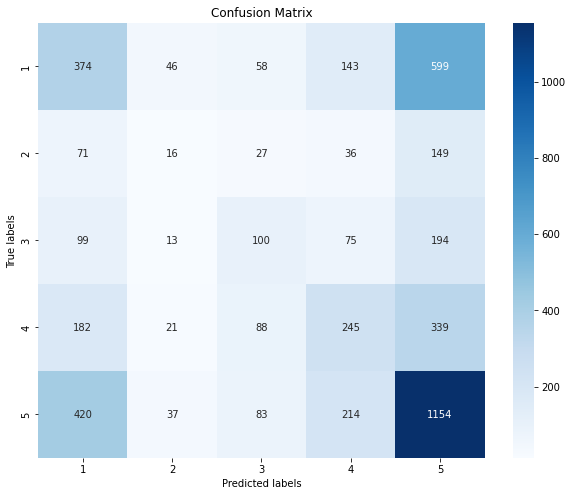

In [10]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the data from the SQLite database
conn = sqlite3.connect('balance_customer_support.db')
data = pd.read_sql_query("SELECT * FROM balanced_customer_support", conn)
conn.close()

# Define the target variable 'y'
y = data['CSAT_Score'].astype('category')  # Ensuring 'y' is a categorical type for stratification

# OneHotEncode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data[['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager']])
encoded_feature_names = encoder.get_feature_names_out(['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category', 'Supervisor', 'Manager'])

# Combine numerical and OneHotEncoded categorical features
X = pd.concat([data[['issue_reported_hour_of_day', 'response_time_minutes', 'issue_reported_day_of_week', 'sentiment_score']], pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names)], axis=1)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define and train MLP classifier
model_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
model_mlp.fit(X_train, y_train)

# Make predictions with the MLP model
y_pred = model_mlp.predict(X_test)

# Classification report
print("MLP Classifier Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
class_labels = y.cat.categories  # This will automatically extract the category labels

conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
